<a href="https://colab.research.google.com/github/danykrayne/DL_2019/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №3. Бинарная сегментация избражений

В работе реализована тренировка сверточной нейронной сети Unet для сегментации левого желудочка на УЗИ изображениях сердца.

In [31]:
!pip install segmentation_models_pytorch

In [32]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import random
import datetime
import pandas as pd
import torch
from torch.utils import data
import segmentation_models_pytorch as smp
from torch import nn 
import torch.nn.functional as F
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Директория датасета состоит из двух директорий, в одной лежат изображения, в другой лежат разметка.

In [34]:
path = r'/content/drive/My Drive/colab data/datasets/segmentation/ultrasound'
os.listdir(path)

['labels', 'images']

Необходимо собрать все изображения и разметки из директорий

In [0]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'labels':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

Проверим, что названия в папке images и labels совпадают.

In [0]:
for img_pth, lbl_pth in zip(img_pathes, lbl_pathes):
    if os.path.join(*img_pth.split('\\')[-3:]) != os.path.join(*lbl_pth.split('\\')[-3:]):
        print('Каталоги не одинаковые')
        break

Каталоги не одинаковые


Реализуем класс Dataset

In [0]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'labels':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

Визаулизируем УЗИ-кадры и бинарные маски для кадров.

In [0]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

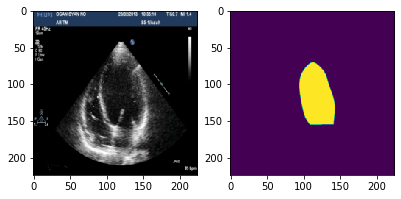

In [0]:
img, msk = train_data[0]
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(msk.squeeze().numpy())

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

Используем модель Unet для сегментации снимков из библиотеки segmentation_models (https://github.com/qubvel/segmentation_models.pytorch).

In [0]:
model = smp.Unet().to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.1MB/s]


Определяем функцию ошибки бинарную кроссэнтропию. Установи шаг обучения для энкодера и декодера сети, причем энкодер будет обучать медленнее.

In [0]:
loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [0]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [0]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:21<00:00,  7.42s/it, bce_loss - 1.333, iou_score - 0.08273, fscore - 0.1526]

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, bce_loss - 0.7917, iou_score - 0.3024, fscore - 0.4618]

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, bce_loss - 0.6097, iou_score - 0.5228, fscore - 0.6856]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, bce_loss - 0.5413, iou_score - 0.6498, fscore - 0.7871]

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, bce_loss - 0.5197, iou_score - 0.6881, fscore - 0.8149]

Epoch: 5
valid: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s, bce_loss - 0.5012, iou_score - 0.7248, fscore - 0.8404]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 3/3 [00:00<00:00,  7.62it/s, bce_loss - 0.4953, iou_score - 0.7319, fscore - 0.8451]

Epoch: 7
valid: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s, bce_loss - 0.491, iou_score - 0.7416, fscore - 0.8516]

Epoch: 8

In [0]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s, bce_loss - 0.4842, iou_score - 0.7648, fscore - 0.8639]


{'bce_loss': 0.4841762279209338,
 'fscore': 0.8638715712647689,
 'iou_score': 0.7648220658302308}

Максимальное значение на валидации iou метрики - 77% и f-score - 87%. На тесте iou - 77%, f-score - 86%.

Возьмем другую функцию ошибки Dice и построим модель сегментации.

In [0]:
model = smp.Unet().to(device)

loss = smp.utils.losses.BCEDiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [0]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|█████████████████████| 3/3 [00:00<00:00,  8.75it/s, bce_dice_loss - 2.401, iou - 0.06102, f-score - 0.1149]

Epoch: 1
valid: 100%|██████████████████████| 3/3 [00:00<00:00,  8.46it/s, bce_dice_loss - 1.538, iou - 0.1728, f-score - 0.2937]

Epoch: 2
valid: 100%|███████████████████████| 3/3 [00:00<00:00,  8.29it/s, bce_dice_loss - 1.208, iou - 0.5402, f-score - 0.699]

Epoch: 3
valid: 100%|██████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.117, iou - 0.7337, f-score - 0.8464]

Epoch: 4
valid: 100%|████████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.1, iou - 0.6998, f-score - 0.8232]

Epoch: 5
valid: 100%|███████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.104, iou - 0.631, f-score - 0.7732]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.082, iou - 0.7108, f-score - 0.8309]

Epoch: 7
valid: 100%|███████████████████████| 3/3

In [0]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:00<00:00, 53.03it/s, bce_loss - 0.4842, iou_score - 0.7648, fscore - 0.8639]


{'bce_loss': 0.4841762279209338,
 'fscore': 0.8638715712647689,
 'iou_score': 0.7648220658302308}

Максимальное значение на валидации iou метрики - 79% и f-score - 88%. На тесте iou - 78%, f-score - 88%.

In [0]:
img, mask_true = test_data[0]
mask_pred = F.sigmoid(model(img.unsqueeze(0).to(device)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


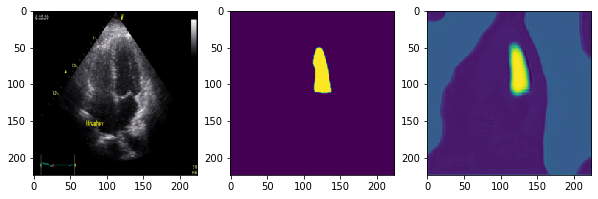

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(mask_true.squeeze().numpy())
plt.subplot(133)
plt.imshow(mask_pred.squeeze().cpu().detach().numpy())

# Задача

Натренировать Unet для сегментации людей на изображении. Использовать датасет 'person segmentation' по ссылке https://drive.google.com/open?id=1yi7Flk_Whidr2OZNdfmGkpgxbQPwIVtr.
Натрениройте несколько моделей Unet с различными энкодерами, проведите анализ качества полученных моделей. Сведите результаты в таблицу по всем моделям и для каждой подвиборке (train, valid, test). Приведите примеры кадров с людьми.

In [35]:
path = r'/content/drive/My Drive/colab data/datasets/segmentation/person_segmentation/train'
os.listdir(path)

['masks', 'images']

In [0]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'masks':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [43]:
for img_pth, lbl_pth in zip(img_pathes, lbl_pathes):
    if os.path.splitext(os.path.basename(img_pth))[-2] != os.path.splitext(os.path.basename(lbl_pth))[-2]:
        print('Каталоги не одинаковые')
        break

Каталоги не одинаковые


In [0]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'masks':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [0]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

18


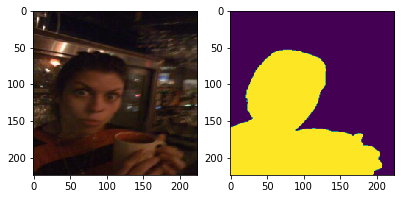

In [46]:
indx=random.randint(0,len(test_data)-1)
print(indx)
img, msk = test_data[indx]
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(msk.squeeze().numpy())

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

In [0]:
lr_results={}

In [50]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-3->1e-5 e 1e-5'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
               
    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()

valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|██████████| 19/19 [02:56<00:00,  8.49s/it, bce_loss - 0.1674, iou_score - 0.9087, fscore - 0.9521]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  7.90it/s, bce_loss - 0.1369, iou_score - 0.9383, fscore - 0.9682]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.42it/s, bce_loss - 0.1203, iou_score - 0.946, fscore - 0.9722]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  8.16it/s, bce_loss - 0.1103, iou_score - 0.9434, fscore - 0.9708]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  7.89it/s, bce_loss - 0.1048, iou_score - 0.9476, fscore - 0.9731]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  8.01it/s, bce_loss - 0.09654, iou_score - 0.9516, fscore - 0.9752]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.78it/s, bce_loss - 0.09466, iou_score - 0.9523, fscore - 0.9756]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.78it/s, bce_loss - 0.09431, iou_score - 0.954, fscore -

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 150/150 [00:02<00:00, 65.57it/s, bce_loss - 0.2854, iou_score - 0.8799, fscore - 0.9254]


{'bce_loss': 0.2853718002140522,
 'fscore': 0.9254288281997046,
 'iou_score': 0.87989597539107}

In [51]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-3 e 1e-5'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  7.75it/s, bce_loss - 0.3017, iou_score - 0.8228, fscore - 0.9024]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  7.73it/s, bce_loss - 0.2916, iou_score - 0.8174, fscore - 0.8992]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.35it/s, bce_loss - 0.2505, iou_score - 0.9339, fscore - 0.9658]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.98it/s, bce_loss - 0.2256, iou_score - 0.93, fscore - 0.9637]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  7.92it/s, bce_loss - 0.24, iou_score - 0.9003, fscore - 0.9474]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.94it/s, bce_loss - 0.2051, iou_score - 0.9433, fscore - 0.9708]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.81it/s, bce_loss - 0.1818, iou_score - 0.9517, fscore - 0.9752]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.97it/s, bce_loss - 0.1754, iou_score - 0.9479, fscore - 0.9732]

Epoch: 8
valid: 100%|██████████| 19

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 150/150 [00:02<00:00, 62.61it/s, bce_loss - 0.3134, iou_score - 0.8803, fscore - 0.926]


{'bce_loss': 0.31339405735333764,
 'fscore': 0.925955004294713,
 'iou_score': 0.8803419299920401}

In [52]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-5},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-5 e 1e-5'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  7.86it/s, bce_loss - 0.607, iou_score - 0.262, fscore - 0.4148]

Epoch: 1
valid: 100%|██████████| 19/19 [00:03<00:00,  5.98it/s, bce_loss - 0.5145, iou_score - 0.3416, fscore - 0.5088]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  8.01it/s, bce_loss - 0.4137, iou_score - 0.4972, fscore - 0.6637]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.98it/s, bce_loss - 0.3693, iou_score - 0.5736, fscore - 0.7286]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  8.12it/s, bce_loss - 0.3239, iou_score - 0.6781, fscore - 0.8078]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.86it/s, bce_loss - 0.2748, iou_score - 0.8004, fscore - 0.889]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.89it/s, bce_loss - 0.2507, iou_score - 0.8529, fscore - 0.9205]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.92it/s, bce_loss - 0.2338, iou_score - 0.8767, fscore - 0.9342]

Epoch: 8
valid: 100%|██████████| 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 150/150 [00:02<00:00, 67.47it/s, bce_loss - 0.3124, iou_score - 0.8564, fscore - 0.9126]


{'bce_loss': 0.3123821770151458,
 'fscore': 0.9126411086320876,
 'iou_score': 0.856400204002857}

In [53]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-3 e 1e-3'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  7.94it/s, bce_loss - 0.2148, iou_score - 0.8513, fscore - 0.9195]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  7.83it/s, bce_loss - 0.1736, iou_score - 0.8938, fscore - 0.9438]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  8.11it/s, bce_loss - 0.1595, iou_score - 0.92, fscore - 0.9582]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.93it/s, bce_loss - 0.1408, iou_score - 0.9171, fscore - 0.9566]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  8.36it/s, bce_loss - 0.1637, iou_score - 0.8999, fscore - 0.9472]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  8.23it/s, bce_loss - 0.1441, iou_score - 0.9143, fscore - 0.9551]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.55it/s, bce_loss - 0.1583, iou_score - 0.8894, fscore - 0.9414]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.85it/s, bce_loss - 0.1354, iou_score - 0.9209, fscore - 0.9587]

Epoch: 8
valid: 100%|██████████| 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 150/150 [00:02<00:00, 68.74it/s, bce_loss - 0.3746, iou_score - 0.8663, fscore - 0.9178]


{'bce_loss': 0.37459434837102884,
 'fscore': 0.9178432873884836,
 'iou_score': 0.8662937527894976}

In [55]:
model = smp.Unet().to(device)

loss = smp.utils.losses.DiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
        
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  8.06it/s, dice_loss - 1.368, iou_score - 0.1885, fscore - 0.3166]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  8.08it/s, dice_loss - -0.5314, iou_score - 0.516, fscore - 0.6802]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.98it/s, dice_loss - 2.147, iou_score - 0.5741, fscore - 0.7291]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  8.08it/s, dice_loss - -6.032, iou_score - 0.507, fscore - 0.6723]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  7.74it/s, dice_loss - -2.479, iou_score - 0.3456, fscore - 0.5128]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.51it/s, dice_loss - 1.067, iou_score - 0.2984, fscore - 0.4589]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.85it/s, dice_loss - 1.35, iou_score - 0.2965, fscore - 0.4567]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  8.23it/s, dice_loss - 1.023, iou_score - 0.3259, fscore - 0.4909]

Epoch: 8
valid: 100%|█████████

{'dice_loss': 0.15608422756195062,
 'fscore': 0.6371211748321852,
 'iou_score': 0.4827616391827664}

In [0]:
results={}

In [58]:
for encoder in [
                'vgg11','vgg16','vgg19',
                'densenet121','densenet201',
                'inceptionresnetv2',
                'resnet18','resnet50','resnet152'
               ]:
    
    print(encoder)
    torch.cuda.empty_cache()
    
    model = smp.Unet(encoder).to(device)    
   
    loss = smp.utils.losses.DiceLoss(eps=1.)

    metrics = [
        smp.utils.metrics.IoU(eps=1.),
        smp.utils.metrics.Fscore(eps=1.),
    ]

    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-3},     

        {'params': model.encoder.parameters(), 'lr': 1e-5},  
    ])

    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )
    
    results[encoder]={}
    
    start_dttm=datetime.datetime.now()
    
    scores=[]
    
    for i in range(0, 20):
        torch.cuda.empty_cache()        
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        with torch.no_grad():
            valid_logs = valid_epoch.run(valid_loader)
        
        scores.append({'train':train_logs,'valid':valid_logs})
      
    results[encoder]['time']=str(datetime.datetime.now()-start_dttm)
    
    results[encoder]['epochs']=scores
    
    with torch.no_grad():
        results[encoder]['test']=valid_epoch.run(test_loader)
    
    img, mask_true = test_data[indx]
    
    results[encoder]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    model=model.cpu()
    loss=loss.cpu()
    metrics[0]=metrics[0].cpu()
    metrics[1]=metrics[1].cpu()
    del model, loss, train_epoch, valid_epoch, optimizer, metrics
    torch.cuda.empty_cache() 

vgg11

Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  7.57it/s, dice_loss - -0.7749, iou_score - 0.6331, fscore - 0.7752]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  7.48it/s, dice_loss - 1.07, iou_score - 0.1688, fscore - 0.2879]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.60it/s, dice_loss - -0.2036, iou_score - 0.2821, fscore - 0.4384]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.57it/s, dice_loss - 0.2964, iou_score - 0.1919, fscore - 0.3211]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  7.90it/s, dice_loss - 15.51, iou_score - 0.3039, fscore - 0.4656]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.50it/s, dice_loss - -1.051, iou_score - 0.3773, fscore - 0.5475]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.54it/s, dice_loss - -1.233, iou_score - 0.5612, fscore - 0.7187]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.64it/s, dice_loss - -1.691, iou_score - 0.7118, fscore - 0.8314]

Epoch: 8
valid: 10

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 41.9MB/s]



Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s, dice_loss - -0.2254, iou_score - 0.1939, fscore - 0.324]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  6.48it/s, dice_loss - 0.4694, iou_score - 0.2251, fscore - 0.3668]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.01it/s, dice_loss - 0.7756, iou_score - 0.1429, fscore - 0.2497]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s, dice_loss - 1.812, iou_score - 0.1599, fscore - 0.2754]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  6.44it/s, dice_loss - -1.606, iou_score - 0.1693, fscore - 0.2892]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.14it/s, dice_loss - 0.7048, iou_score - 0.1752, fscore - 0.2975]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  6.86it/s, dice_loss - 2.525, iou_score - 0.06772, fscore - 0.1267]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  6.89it/s, dice_loss - 2.301, iou_score - 0.06057, fscore - 0.114]

Epoch: 8
valid: 100%|████

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:15<00:00, 36.7MB/s]



Epoch: 0
valid: 100%|██████████| 19/19 [00:03<00:00,  6.77it/s, dice_loss - -0.9079, iou_score - 0.7212, fscore - 0.8377]

Epoch: 1
valid: 100%|██████████| 19/19 [00:03<00:00,  6.67it/s, dice_loss - -0.9975, iou_score - 0.6369, fscore - 0.7774]

Epoch: 2
valid: 100%|██████████| 19/19 [00:03<00:00,  6.71it/s, dice_loss - -0.4212, iou_score - 0.4328, fscore - 0.6032]

Epoch: 3
valid: 100%|██████████| 19/19 [00:03<00:00,  6.66it/s, dice_loss - -1.327, iou_score - 0.4734, fscore - 0.642]

Epoch: 4
valid: 100%|██████████| 19/19 [00:03<00:00,  6.97it/s, dice_loss - -1.306, iou_score - 0.4949, fscore - 0.6615]

Epoch: 5
valid: 100%|██████████| 19/19 [00:03<00:00,  6.66it/s, dice_loss - -1.56, iou_score - 0.4468, fscore - 0.6167]

Epoch: 6
valid: 100%|██████████| 19/19 [00:03<00:00,  6.64it/s, dice_loss - -1.507, iou_score - 0.4172, fscore - 0.5876]

Epoch: 7
valid: 100%|██████████| 19/19 [00:03<00:00,  6.72it/s, dice_loss - -1.909, iou_score - 0.3582, fscore - 0.5262]

Epoch: 8
valid: 100%|█

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/checkpoints/densenet121-fbdb23505.pth
100%|██████████| 30.9M/30.9M [01:30<00:00, 356kB/s]


Epoch: 0
train:   0%|          | 0/66 [00:00<?, ?it/s]

valid: 100%|██████████| 19/19 [00:02<00:00,  7.45it/s, dice_loss - 1.45, iou_score - 0.09118, fscore - 0.1657]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  6.86it/s, dice_loss - 1.455, iou_score - 0.1043, fscore - 0.1879]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s, dice_loss - 1.309, iou_score - 0.1043, fscore - 0.1877]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s, dice_loss - 1.146, iou_score - 0.09229, fscore - 0.1679]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  6.93it/s, dice_loss - 0.8703, iou_score - 0.1157, fscore - 0.2063]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.40it/s, dice_loss - 0.4148, iou_score - 0.2141, fscore - 0.3515]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  6.98it/s, dice_loss - 0.8032, iou_score - 0.09088, fscore - 0.1654]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  6.95it/s, dice_loss - 0.7942, iou_score - 0.06884, fscore - 0.1276]

Epoch: 8
valid: 100%|██████████| 1

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet201-5750cbb1e.pth" to /root/.cache/torch/checkpoints/densenet201-5750cbb1e.pth
100%|██████████| 77.4M/77.4M [03:48<00:00, 356kB/s]



Epoch: 0
valid: 100%|██████████| 19/19 [00:03<00:00,  6.27it/s, dice_loss - -0.674, iou_score - 0.3583, fscore - 0.5266]

Epoch: 1
valid: 100%|██████████| 19/19 [00:03<00:00,  5.99it/s, dice_loss - -0.2582, iou_score - 0.2482, fscore - 0.3965]

Epoch: 2
valid: 100%|██████████| 19/19 [00:03<00:00,  6.20it/s, dice_loss - 1.709, iou_score - 0.1409, fscore - 0.2432]

Epoch: 3
valid: 100%|██████████| 19/19 [00:03<00:00,  6.17it/s, dice_loss - 1.311, iou_score - 0.1568, fscore - 0.2672]

Epoch: 4
valid: 100%|██████████| 19/19 [00:03<00:00,  6.11it/s, dice_loss - 1.061, iou_score - 0.1669, fscore - 0.2823]

Epoch: 5
valid: 100%|██████████| 19/19 [00:03<00:00,  6.54it/s, dice_loss - 1.012, iou_score - 0.1644, fscore - 0.2785]

Epoch: 6
valid: 100%|██████████| 19/19 [00:03<00:00,  6.26it/s, dice_loss - 0.4991, iou_score - 0.2048, fscore - 0.3367]

Epoch: 7
valid: 100%|██████████| 19/19 [00:03<00:00,  6.52it/s, dice_loss - 0.4562, iou_score - 0.2025, fscore - 0.3334]

Epoch: 8
valid: 100%|█████

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth
100%|██████████| 213M/213M [10:28<00:00, 356kB/s]



Epoch: 0
valid: 100%|██████████| 19/19 [00:03<00:00,  5.66it/s, dice_loss - 3.079, iou_score - 0.1854, fscore - 0.3122]

Epoch: 1
valid: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s, dice_loss - 1.534, iou_score - 0.05749, fscore - 0.1085]

Epoch: 2
valid: 100%|██████████| 19/19 [00:03<00:00,  5.60it/s, dice_loss - 1.221, iou_score - 0.06057, fscore - 0.1139]

Epoch: 3
valid: 100%|██████████| 19/19 [00:04<00:00,  5.25it/s, dice_loss - 1.059, iou_score - 0.09065, fscore - 0.1659]

Epoch: 4
valid: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s, dice_loss - 1.045, iou_score - 0.08865, fscore - 0.1624]

Epoch: 5
valid: 100%|██████████| 19/19 [00:03<00:00,  5.46it/s, dice_loss - 0.8414, iou_score - 0.1201, fscore - 0.2139]

Epoch: 6
valid: 100%|██████████| 19/19 [00:03<00:00,  5.60it/s, dice_loss - 0.7761, iou_score - 0.1199, fscore - 0.2135]

Epoch: 7
valid: 100%|██████████| 19/19 [00:03<00:00,  5.59it/s, dice_loss - 1.173, iou_score - 0.1369, fscore - 0.24]

Epoch: 8
valid: 100%|██████

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.6MB/s]



Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  8.60it/s, dice_loss - -0.6934, iou_score - 0.413, fscore - 0.5841]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  8.38it/s, dice_loss - -1.281, iou_score - 0.1611, fscore - 0.275]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  8.29it/s, dice_loss - -0.921, iou_score - 0.2886, fscore - 0.446]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  8.28it/s, dice_loss - -0.7716, iou_score - 0.04226, fscore - 0.08055]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  8.13it/s, dice_loss - -0.02342, iou_score - 0.3306, fscore - 0.4956]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.88it/s, dice_loss - -3.534, iou_score - 0.2608, fscore - 0.4121]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  8.40it/s, dice_loss - 0.5568, iou_score - 0.1997, fscore - 0.3323]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  8.15it/s, dice_loss - 0.5555, iou_score - 0.2233, fscore - 0.3636]

Epoch: 8
valid: 100%

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 51.7MB/s]



Epoch: 0
valid: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s, dice_loss - 1.069, iou_score - 0.005837, fscore - 0.01155]

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s, dice_loss - 0.9839, iou_score - 0.3533, fscore - 0.5202]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.14it/s, dice_loss - -2.336, iou_score - 0.1248, fscore - 0.2213]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s, dice_loss - 1.849, iou_score - 0.06845, fscore - 0.1265]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s, dice_loss - 1.779, iou_score - 0.067, fscore - 0.124]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.30it/s, dice_loss - 1.576, iou_score - 0.07468, fscore - 0.1375]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s, dice_loss - 1.358, iou_score - 0.08794, fscore - 0.1599]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.05it/s, dice_loss - 1.589, iou_score - 0.07514, fscore - 0.1381]

Epoch: 8
valid: 100%|███

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:05<00:00, 44.5MB/s]



Epoch: 0
valid: 100%|██████████| 19/19 [00:03<00:00,  6.17it/s, dice_loss - 0.927, iou_score - 0.2199, fscore - 0.3581]

Epoch: 1
valid: 100%|██████████| 19/19 [00:03<00:00,  6.25it/s, dice_loss - 0.007528, iou_score - 0.4394, fscore - 0.6096]

Epoch: 2
valid: 100%|██████████| 19/19 [00:03<00:00,  6.05it/s, dice_loss - 12.77, iou_score - 0.4034, fscore - 0.5743]

Epoch: 3
valid: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s, dice_loss - -0.4305, iou_score - 0.1522, fscore - 0.2612]

Epoch: 4
valid: 100%|██████████| 19/19 [00:03<00:00,  6.09it/s, dice_loss - 0.2777, iou_score - 0.2087, fscore - 0.3427]

Epoch: 5
valid: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s, dice_loss - 1.041, iou_score - 0.1196, fscore - 0.2117]

Epoch: 6
valid: 100%|██████████| 19/19 [00:03<00:00,  5.96it/s, dice_loss - 0.8545, iou_score - 0.1369, fscore - 0.2387]

Epoch: 7
valid: 100%|██████████| 19/19 [00:03<00:00,  6.11it/s, dice_loss - 0.6319, iou_score - 0.1628, fscore - 0.2776]

Epoch: 8
valid: 100%|██

In [0]:
res=pd.DataFrame()
for encoder in results:
    results[encoder]
    
    d={'encoder':encoder}
    
    d['time']=results[encoder]['time']
    
    d.update({'train_'+k:v for k,v in sorted(results[encoder]['epochs'], key=lambda x: x['train']['fscore'], reverse=True)[0]['train'].items()})
    
    d.update({'valid_'+k:v for k,v in sorted(results[encoder]['epochs'], key=lambda x: x['valid']['fscore'], reverse=True)[0]['valid'].items()})
    
    d.update({'test_'+k:v for k,v in results[encoder]['test'].items()})
    
    res=res.append([d], ignore_index=True)

vgg11


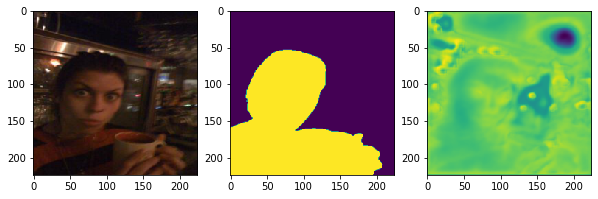

vgg16


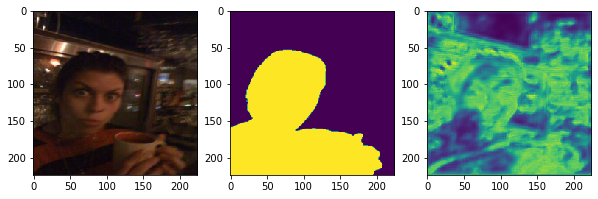

vgg19


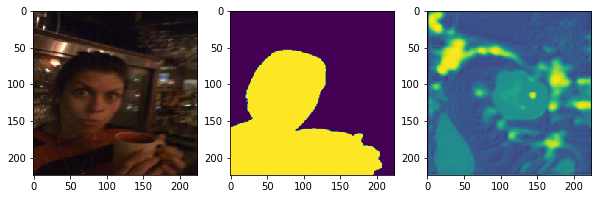

densenet121


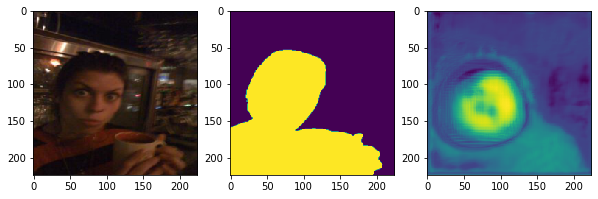

densenet201


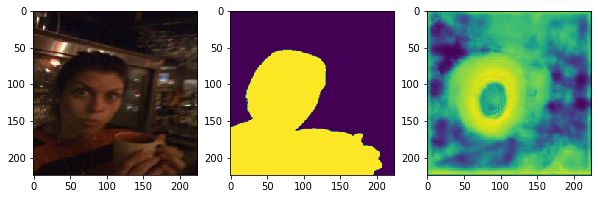

inceptionresnetv2


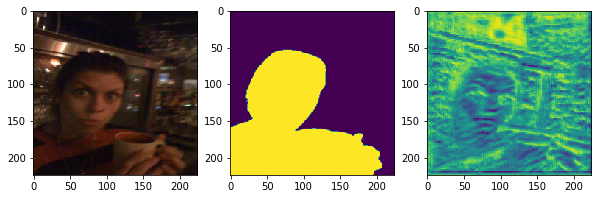

resnet18


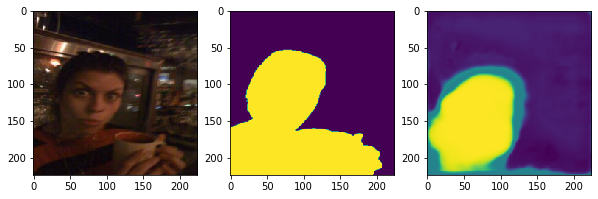

resnet50


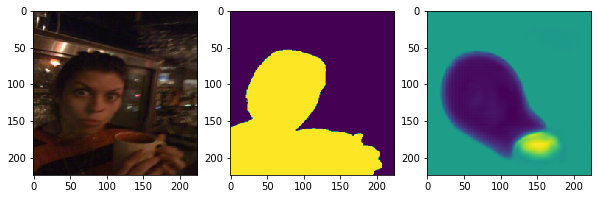

resnet152


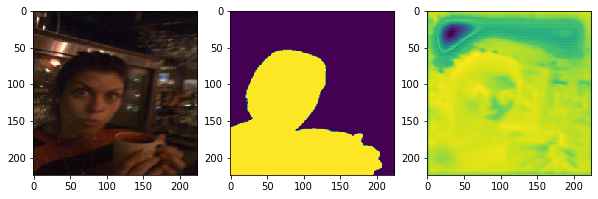

In [68]:
img, mask_true = test_data[indx]
for encoder in results:
    print(encoder)
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.subplot(132)
    plt.imshow(mask_true.squeeze().numpy())
    plt.subplot(133)
    plt.imshow(results[encoder]['pred'])
    plt.pause(0.1)

In [0]:
res=pd.DataFrame()
for lr in lr_results:
    lr_results[lr]
    
    d={'lr':lr}
    
    d['time']=lr_results[lr]['time']
    
    d.update({'train_'+k:v for k,v in sorted(lr_results[lr]['epochs'], key=lambda x: x['train']['fscore'], reverse=True)[0]['train'].items()})
    
    d.update({'valid_'+k:v for k,v in sorted(lr_results[lr]['epochs'], key=lambda x: x['valid']['fscore'], reverse=True)[0]['valid'].items()})
    
    d.update({'test_'+k:v for k,v in lr_results[lr]['test'].items()})
    
    res=res.append([d], ignore_index=True)

In [70]:
res

,lr,time,train_bce_loss,train_iou_score,train_fscore,valid_bce_loss,valid_iou_score,valid_fscore,test_bce_loss,test_iou_score,test_fscore
0,d 1e-3->1e-5 e 1e-5,0:18:35.616420,0.062571,0.975988,0.987845,0.097138,0.955808,0.977393,0.285372,0.879896,0.925429
1,d 1e-3 e 1e-5,0:05:17.835909,0.105041,0.977677,0.988710,0.140377,0.955508,0.977232,0.313394,0.880342,0.925955
2,d 1e-5 e 1e-5,0:05:17.128945,0.163234,0.952430,0.975594,0.187533,0.932045,0.964806,0.312382,0.856400,0.912641
3,d 1e-3 e 1e-3,0:05:15.494778,0.041513,0.975460,0.987575,0.110936,0.941268,0.969695,0.374594,0.866294,0.917843


d 1e-3->1e-5 e 1e-5


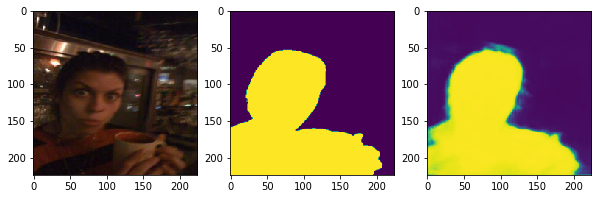

d 1e-3 e 1e-5


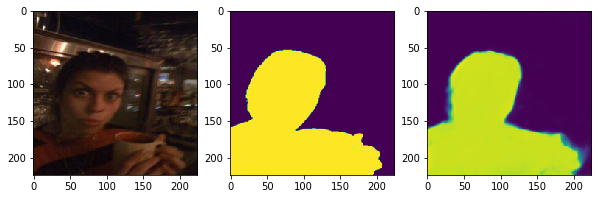

d 1e-5 e 1e-5


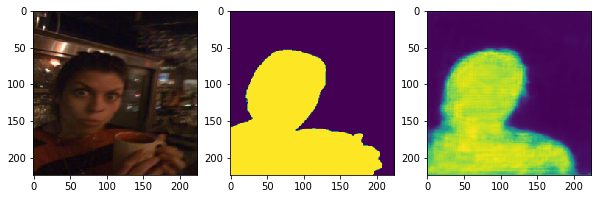

d 1e-3 e 1e-3


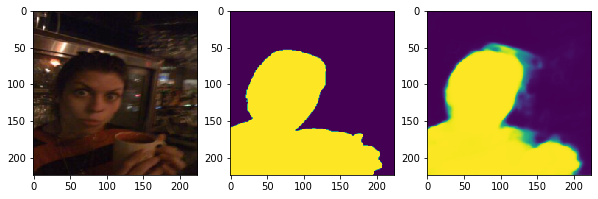

In [71]:
img, mask_true = test_data[indx]
for lr in lr_results:
    print(lr)
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.subplot(132)
    plt.imshow(mask_true.squeeze().numpy())
    plt.subplot(133)
    plt.imshow(lr_results[lr]['pred'])
    plt.pause(0.1)